### This notebook provides a first analysis of the Markov Chain idea for actors: ###
We will try to build a transition matrix of the roles that an actor can have throughout his life.
Then we can derive some interesting insights such as how to begin your career, what roles are you likely to have at the end of your career ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from src import Helpers

In [2]:
character_df = Helpers.load_data("character.metadata.tsv")

character_df.head()

,Wiki_movie_id,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Freebase character/actor map ID,Fb_char_id,Fb_actor_id
0,975900,03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,0bgchxw,0bgcj3x,03wcfv7
1,975900,03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,044038p,Natasha Henstridge,27.0,0jys3m,0bgchn4,0346l4
2,975900,03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,0x67,Ice Cube,32.0,0jys3g,0bgchn_,01vw26l
3,975900,03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,02vchl6,0bgchnq,034hyc
4,975900,03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,02vbb3r,0bgchp9,01y9xg


In [3]:
tvtropes_df = Helpers.load_data("tvtropes.clusters.txt")

tvtropes_df.head()

,CharType,Char,Movie,Fb_char_actor_id,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader


#### The first thing is that we will keep track of the i-th movie it is for each actor (we only consider major roles i.e. when we know the character name)

In [4]:
# Sort the DataFrame by 'Fb_actor_id', 'Actor_age', and 'Character'
character_df = character_df.sort_values(['Fb_actor_id', 'Actor_age', 'Character'])

# Create a mask to identify the major roles (Character is not NaN)
major_role_mask = character_df['Character'].notna()

# Calculate the i-th film for each actor based on major roles
character_df['Film_Index'] = (major_role_mask.groupby(character_df['Fb_actor_id']).cumsum()
                    .where(major_role_mask, np.nan))  # Set 0 for minor roles
stat = character_df[character_df['Actor_name']== "Johnny Depp"]
stat.head()

,Wiki_movie_id,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Freebase character/actor map ID,Fb_char_id,Fb_actor_id,Film_Index
120977,3028191,08ll52,1984.0,Glen Lantz,1963-06-09,M,1.78,01qhm_,Johnny Depp,21.0,0jsvh6,0csqbm,0jfx1,1.0
351263,3514297,09hq9g,1985.0,Jack,1963-06-09,M,1.78,01qhm_,Johnny Depp,21.0,03lfl4k,04fll8n,0jfx1,2.0
22381,19315787,04lgx5r,1986.0,Donnie Fleischer,1963-06-09,M,1.78,01qhm_,Johnny Depp,23.0,04q4cj_,0gxq38m,0jfx1,3.0
229949,113460,0sxmx,1986.0,Gator Lerner,1963-06-09,M,1.78,01qhm_,Johnny Depp,23.0,0k1yz8,02nwky0,0jfx1,4.0
441458,6614818,0gdv4x,1989.0,NaN,1963-06-09,M,1.78,01qhm_,Johnny Depp,25.0,0h9hhm2,NaN,0jfx1,NaN


#### We can study if the movie industry give their chance to new actors throughout time (knowing that this process is not relevant for the first years of the dataset)

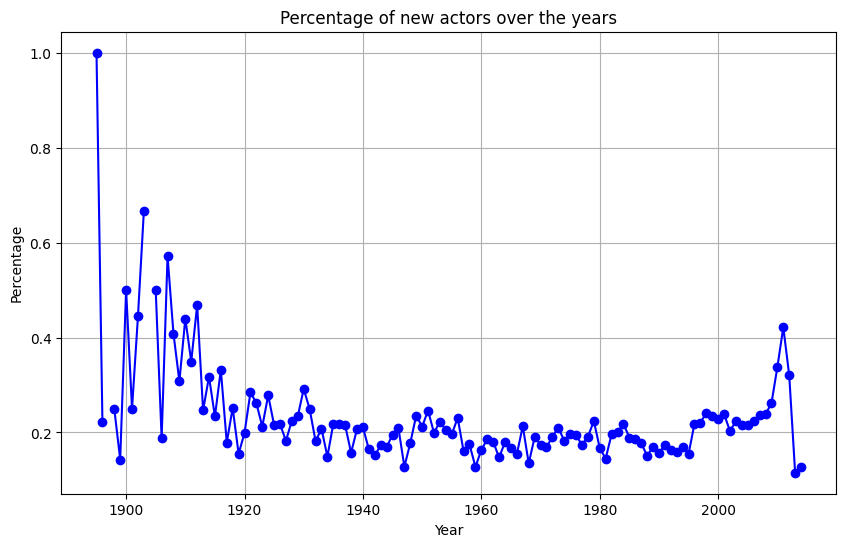

In [5]:
# Filter major roles (Character is not NaN)
major_roles = character_df[character_df['Character'] != 'NaN']

# Group by release date and calculate the number of actors with Film_Index equal to 1 or higher
actors_by_year = major_roles.groupby('release_date')['Fb_actor_id'].nunique()

# Group by release date and calculate the number of actors with Film_Index equal to 1
actors_with_index_1_by_year = major_roles[major_roles['Film_Index'] == 1].groupby('release_date')['Fb_actor_id'].nunique()

# Calculate the ratio of actors with Film_Index 1 to actors with Film_Index 1 or higher for each year
ratio = actors_with_index_1_by_year / actors_by_year

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(ratio.index, ratio, marker='o', linestyle='-', color='b')
plt.title('Percentage of new actors over the years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.show()

#### It seems that starting from 2000 more newcomers where given a chance to start a career at Holywood

In [10]:
# Perform an outer merge to retain all rows
merged_data = character_df.merge(tvtropes_df, left_on=['Freebase character/actor map ID', 'Character'], right_on=['Fb_char_actor_id', 'Char'], how='outer')
# Drop the specified columns
merged_data.drop(columns=['Actor', 'Char', 'Movie'], inplace=True)

# Drop rows with NaN values in the 'CharType' column
merged_data.dropna(subset=['CharType'], inplace=True)
# Display the merged data
print(merged_data.shape)
merged_data.head()


(501, 16)


,Wiki_movie_id,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Freebase character/actor map ID,Fb_char_id,Fb_actor_id,Film_Index,CharType,Fb_char_actor_id
680,2087781,06l9q0,1985.0,Jake,1955-01-18,M,1.850,09vc4s,Kevin Costner,30.0,0k39jj,0g_vt8w,0127m7,5.0,young_gun,0k39jj
1720,142430,011yhm,1996.0,Gaear Grimsrud,1953-08-27,M,1.892,065b6q,Peter Stormare,42.0,0jy2x0,04mn0r0,012q4n,1.0,psycho_for_hire,0jy2x0
2053,598397,02t_h3,2004.0,Shaun,1970-02-14,M,1.780,NaN,Simon Pegg,34.0,0k35n0,0gxnhy3,012x2b,6.0,slacker,0k35n0
2062,8172248,026rrf_,2007.0,Dennis,1970-02-14,M,1.780,NaN,Simon Pegg,37.0,03lvx8n,0gxnhw4,012x2b,15.0,loser_protagonist,03lvx8n
2065,14280823,03c_4fq,2008.0,Sidney Young,1970-02-14,M,1.780,NaN,Simon Pegg,38.0,040l_q8,0gxnhyk,012x2b,18.0,loser_protagonist,040l_q8


We note that the number of rows have significantly reduced 

In [12]:
# Get unique values from the 'CharType' column
char_types = merged_data['CharType'].unique()

char_types

array(['young_gun', 'psycho_for_hire', 'slacker', 'loser_protagonist',
       'dirty_cop', 'bounty_hunter', 'adventurer_archaeologist',
       'granola_person', 'corrupt_corporate_executive',
       'henpecked_husband', 'hardboiled_detective', 'ophelia',
       'hitman_with_a_heart', 'evil_prince', 'dumb_blonde',
       'grumpy_old_man', 'consummate_professional', 'byronic_hero',
       'crazy_jealous_guy', 'casanova', 'gadgeteer_genius',
       'egomaniac_hunter', 'heartbroken_badass', 'prima_donna',
       'crazy_survivalist', 'revenge', 'chanteuse', 'warrior_poet',
       'father_to_his_men', 'tranquil_fury', 'fastest_gun_in_the_west',
       'master_swordsman', 'dumb_muscle', 'the_chief', 'jerk_jock',
       'drill_sargeant_nasty', 'valley_girl', 'brainless_beauty',
       'big_man_on_campus', 'cultured_badass', 'retired_outlaw',
       'pupil_turned_to_evil', 'surfer_dude', 'the_editor',
       'playful_hacker', 'officer_and_a_gentleman', 'charmer',
       'loveable_rogue', 'eccen

Based on these categories, we perform a clustering 'On Chat GPT' for the moment but a better way of doing it (maybe using sinopsis could maybe be done).

In [13]:
# The dictionnary which map characters into categories
word_category_mapping = {
    'absent_minded_professor': 'Intellectuals',
    'adventurer_archaeologist': 'Adventurers',
    'arrogant_kungfu_guy': 'Warriors and Fighters',
    'big_man_on_campus': 'Leadership and Authority',
    'bounty_hunter': 'Adventurers',
    'brainless_beauty': 'Comedic and Eccentric',
    'broken_bird': 'Quirky and Unique',
    'bromantic_foil': 'Comedic and Eccentric',
    'bruiser_with_a_soft_center': 'Antiheroes',
    'bully': 'Villains',
    'byronic_hero': 'Antiheroes',
    'casanova': 'Lovers and Romantics',
    'chanteuse': 'Intellectuals',
    'charmer': 'Lovers and Romantics',
    'child_prodigy': 'Intellectuals',
    'classy_cat_burglar': 'Villains',
    'consummate_professional': 'N/A',
    'corrupt_corporate_executive': 'Villains',
    'coward': 'Antiheroes',
    'crazy_jealous_guy': 'Villains',
    'crazy_survivalist': 'Quirky and Unique',
    'cultured_badass': 'Warriors and Fighters',
    'dean_bitterman': 'Leadership and Authority',
    'dirty_cop': 'Villains',
    'ditz': 'Comedic and Eccentric',
    'doormat': 'N/A',
    'drill_sargeant_nasty': 'Leadership and Authority',
    'dumb_blonde': 'Comedic and Eccentric',
    'dumb_muscle': 'Warriors and Fighters',
    'eccentric_mentor': 'Intellectuals',
    'egomaniac_hunter': 'Villains',
    'evil_prince': 'Villains',
    'fastest_gun_in_the_west': 'Warriors and Fighters',
    'father_to_his_men': 'Leadership and Authority',
    'final_girl': 'Classic Heroic Figures',
    'gadgeteer_genius': 'Intellectuals',
    'gentleman_thief': 'Villains',
    'granola_person': 'N/A',
    'grumpy_old_man': 'Quirky and Unique',
    'hardboiled_detective': 'Antiheroes',
    'heartbroken_badass': 'Antiheroes',
    'henpecked_husband': 'Comedic and Eccentric',
    'hitman_with_a_heart': 'Antiheroes',
    'jerk_jock': 'Leadership and Authority',
    'junkie_prophet': 'Quirky and Unique',
    'klutz': 'Comedic and Eccentric',
    'loser_protagonist': 'Antiheroes',
    'loveable_rogue': 'Lovers and Romantics',
    'master_swordsman': 'Warriors and Fighters',
    'morally_bankrupt_banker': 'Villains',
    'officer_and_a_gentleman': 'Leadership and Authority',
    'ophelia': 'Tragic Figures',
    'playful_hacker': 'N/A',
    'prima_donna': 'Comedic and Eccentric',
    'psycho_for_hire': 'Villains',
    'pupil_turned_to_evil': 'Villains',
    'retired_outlaw': 'Villains',
    'revenge': 'Villains',
    'romantic_runnerup': 'Lovers and Romantics',
    'self_made_man': 'Antiheroes',
    'slacker': 'Antiheroes',
    'stoner': 'Antiheroes',
    'storyteller': 'Intellectuals',
    'stupid_crooks': 'Comedic and Eccentric',
    'surfer_dude': 'Adventurers',
    'the_chief': 'Leadership and Authority',
    'the_editor': 'Quirky and Unique',
    'tranquil_fury': 'Warriors and Fighters',
    'trickster': 'Comedic and Eccentric',
    'valley_girl': 'Comedic and Eccentric',
    'warrior_poet': 'Warriors and Fighters',
    'young_gun': 'Classic Heroic Figures'
}

In [15]:
#Then we filter the dataframe
# Add a new column 'Category' to your DataFrame based on the 'CharType' column
merged_data['Category'] = merged_data['CharType'].map(word_category_mapping)

reduced_df = merged_data[['Actor gender','Category','Actor_age','release_date','Film_Index','Fb_actor_id','Actor_name']]
reduced_df

,Actor gender,Category,Actor_age,release_date,Film_Index,Fb_actor_id,Actor_name
680,M,Classic Heroic Figures,30.0,1985.0,5.0,0127m7,Kevin Costner
1720,M,Villains,42.0,1996.0,1.0,012q4n,Peter Stormare
2053,M,Antiheroes,34.0,2004.0,6.0,012x2b,Simon Pegg
2062,M,Antiheroes,37.0,2007.0,15.0,012x2b,Simon Pegg
2065,M,Antiheroes,38.0,2008.0,18.0,012x2b,Simon Pegg
...,...,...,...,...,...,...,...
449277,M,Antiheroes,21.0,1982.0,2.0,0sz28,Sean Penn
449278,M,Adventurers,21.0,1982.0,2.0,0sz28,Sean Penn
449331,M,Villains,36.0,1984.0,9.0,0tc7,Arnold Schwarzenegger
449794,M,Lovers and Romantics,53.0,1991.0,31.0,0z4s,Anthony Hopkins


Then we will track the movies and the categories in each every actor played (note that in this step we don't use the orders of roles (which is something that might be usefull to draw a MC))

In [16]:
# Create a pivot table to count the number of films in each category for each actor
pivot_table = reduced_df.pivot_table(index='Actor_name', columns='Category', values='Film_Index', aggfunc='count', fill_value=0)

# Reset the index and rename the columns
pivot_table.reset_index(inplace=True)
pivot_table.columns.name = None

# Display the resulting DataFrame
pivot_table

# Filter the rows where the sum of values is higher than 1 
# we want to keep only actors who played in more than one film as we want to study the changes of roles that are possible throughout a career
filtered_df = pivot_table[pivot_table.iloc[:, 1:].sum(axis=1) > 1]
filtered_df = filtered_df.set_index('Actor_name')

filtered_df

,Adventurers,Antiheroes,Classic Heroic Figures,Comedic and Eccentric,Intellectuals,Leadership and Authority,Lovers and Romantics,N/A,Quirky and Unique,Tragic Figures,Villains,Warriors and Fighters
Actor_name,,,,,,,,,,,,
Adam Sandler,0,0,0,3,0,0,0,0,0,0,0,1
Al Pacino,0,0,0,0,0,0,0,0,0,0,2,0
Alex Winter,1,1,0,0,0,0,0,0,0,0,0,0
Alicia Silverstone,0,0,0,2,0,0,0,0,0,0,0,0
Anna Faris,0,0,0,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Tony Curran,0,0,0,0,0,0,1,0,0,0,1,0
Tony Leung Chiu Wai,0,0,0,0,0,0,0,0,0,0,0,2
Val Kilmer,0,0,0,0,1,0,0,0,0,0,0,1


c:\Users\erwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


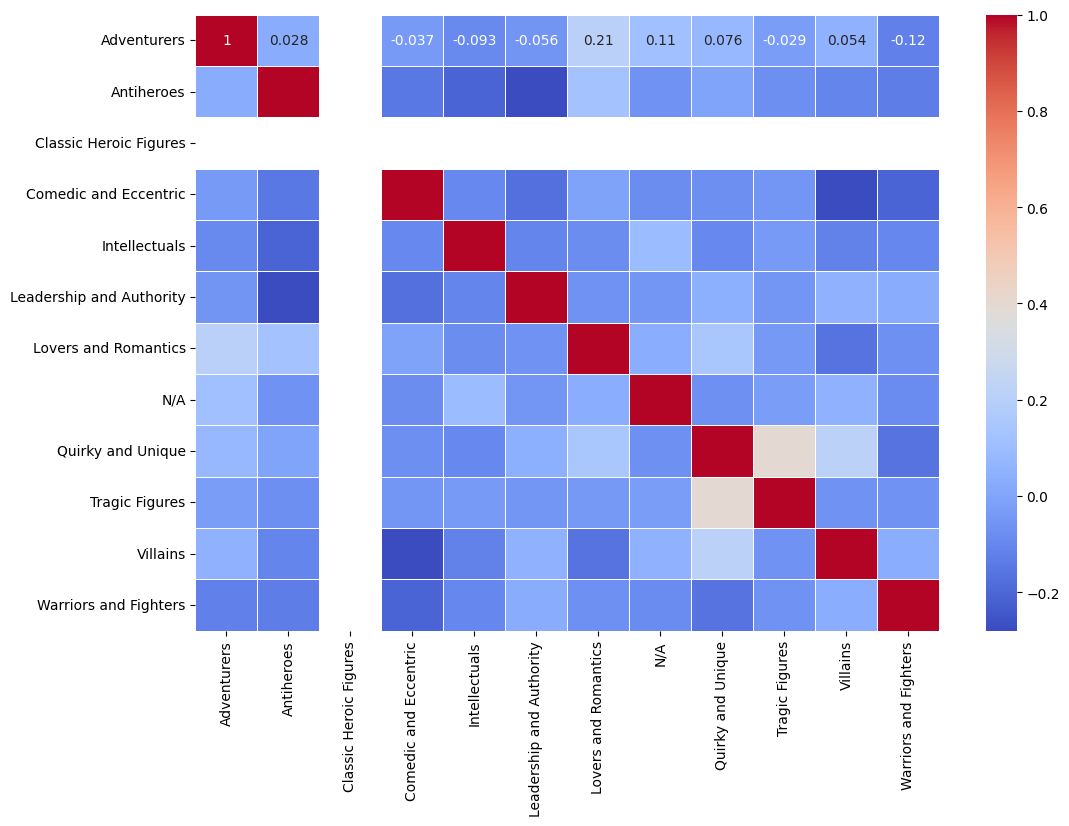

In [17]:
correlation_matrix = filtered_df.corr()

# Set the size of the heatmap
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the plot
plt.show()

Even if not really well designed, this matrix start giving us some good  insights about the compatibility of roles such as for exemple Villains and Lovers and Romantics ...